# IMPORTING DEPENDENCIES

In [58]:
import os
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# DIVIDING THE SOURCE FILE AMONG DIFFERENT HOSPITALS TO PERFORM FEDERATED LEARNING

In [ ]:


SOURCE_ROOT = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/chest_xray/chest_xray"
DEST_ROOT = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL"

HOSPITALS = ["hospital_1", "hospital_2", "hospital_3"]
LOCK_FILE = os.path.join(DEST_ROOT, ".split_done")

def safe_walk(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def main():

    if os.path.exists(LOCK_FILE):
        print("Dataset already split. Script will NOT run again.")
        return

    print("Starting dataset split...")

    for h in HOSPITALS:
        for split in ["train", "val", "test"]:
            ensure_dir(os.path.join(DEST_ROOT, h, split))

    splits = ["train", "test", "val"]

    for split in splits:
        split_path = os.path.join(SOURCE_ROOT, split)
        class_folders = safe_walk(split_path)

        for cls in class_folders:
            cls_path = os.path.join(split_path, cls)
            images = [img for img in os.listdir(cls_path)
                      if img.lower().endswith((".png", ".jpg", ".jpeg"))]

            random.shuffle(images)

            chunk = len(images) // 3
            remainder = len(images) % 3

            chunks = [
                images[i*chunk : (i+1)*chunk] for i in range(3)
            ]


            for i in range(remainder):
                chunks[i].append(images[-(i+1)])


            for i, hospital in enumerate(HOSPITALS):
                dest_class_folder = os.path.join(DEST_ROOT, hospital, split, cls)
                ensure_dir(dest_class_folder)
                for img in chunks[i]:
                    src = os.path.join(cls_path, img)
                    dst = os.path.join(dest_class_folder, img)
                    shutil.copy2(src, dst)

    with open(LOCK_FILE, "w") as f:
        f.write("dataset split completed")

if __name__ == "__main__":
    main()


Dataset already split. Script will NOT run again.


# HOSPITAL 1

### PREPARATION OF DATASET FOR HOSPITAL 1


In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/train",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)


Found 1739 files belonging to 2 classes.


I0000 00:00:1764879125.349776    1431 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/val",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

Found 6 files belonging to 2 classes.


In [4]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/test",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

Found 208 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### VIZUALIZING THE DATASET

2025-12-04 20:12:56.031494: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


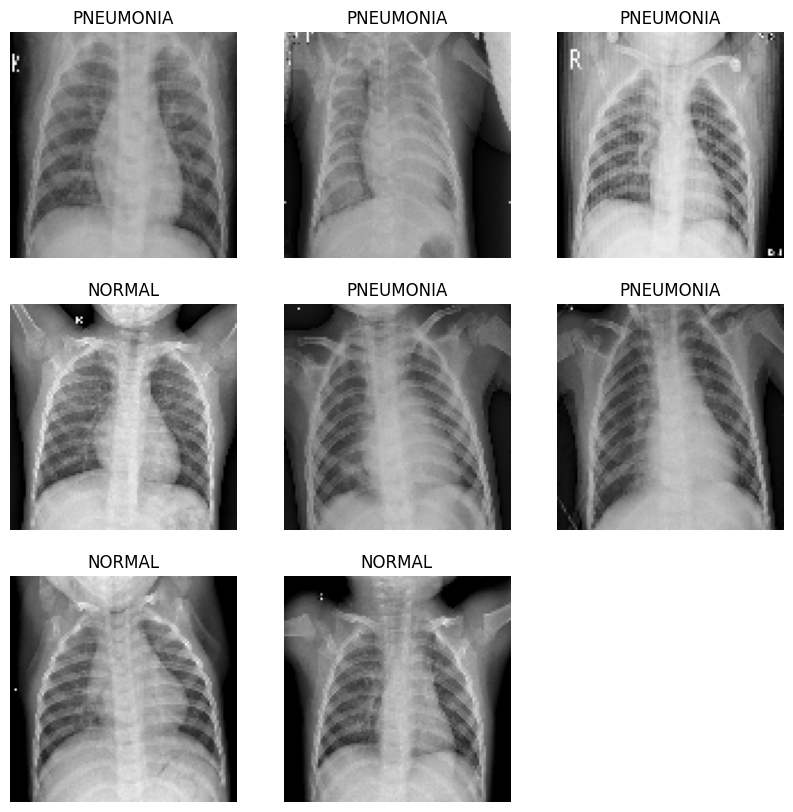

In [6]:
class_names = list(train_dataset.class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = tf.argmax(labels[i]).numpy()
    plt.title(class_names[class_idx])
    plt.axis("off")

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./99)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

In [9]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_ds_hospital_1 = train_dataset.cache().prefetch(buffer_size = 0)
val_ds_hospital_1 = validation_dataset.cache().prefetch(buffer_size = 0)
test_ds_hospital_1 = test_dataset.cache().prefetch(buffer_size = 0)

### MODEL TRAINING FOR HOSPITAL 1


In [12]:
IMG_SHAPE = (100,100,3)
base_model_hospital_1 = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
    include_preprocessing=True
)
base_model_hospital_1.trainable = False

In [58]:
base_model_hospital_1.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 100, 100,  │          0 │ input_layer_11[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 50, 50,    │        648 │ rescaling_7[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 50, 50,    │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 50, 50,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 50, 50,    │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 50, 50,    │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 50, 50,    │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 50, 50,    │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 50, 50,    │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 50, 50,    │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 50, 50,    │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 50, 50,    │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 50, 50,    │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 25, 25,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 25, 25,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 25, 25,    │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,331,360 (77.56 MB)

In [14]:
inputs = tf.keras.Input(shape=(100,100,3))
x = base_model_hospital_1(inputs, training=False)  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model_transfer_hospital_1 = tf.keras.Model(inputs, outputs)

In [15]:
model_transfer_hospital_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 4, 4, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,372,418 (77.71 MB)

 Trainable params: 41,058 (160.38 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [16]:
model_transfer_hospital_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn')],
)

In [38]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'fn',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    mode = 'min',
    restore_best_weights = False
)

In [18]:
history_hospital_1 = model_transfer_hospital_1.fit(
    train_ds_hospital_1,
    validation_data = val_ds_hospital_1,
    epochs = 25,
    callbacks = [callback]
)

Epoch 1/25


2025-12-04 16:49:31.863579: I external/local_xla/xla/service/service.cc:163] XLA service 0x72ae000023d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-04 16:49:31.863642: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-12-04 16:49:32.751084: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-04 16:49:36.109335: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-12-04 16:49:40.238945: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 8 bytes spill stores, 8 bytes spill loads

2025-12-04 16:49:40.297986: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:3

  2/218 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.4375 - f1: 0.4286 - fn: 6.5000 - loss: 0.7360 - pn: 0.4375 - rc: 0.4375   

I0000 00:00:1764867006.779640    2441 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


216/218 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7100 - f1: 0.4768 - fn: 237.2639 - loss: 0.5791 - pn: 0.7100 - rc: 0.7100

2025-12-04 16:50:24.566876: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 8 bytes spill stores, 8 bytes spill loads

2025-12-04 16:50:24.679618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 12 bytes spill stores, 12 bytes spill loads

2025-12-04 16:50:29.619915: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[3,512,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,512,7,7]{3,2,1,0}, f32[512,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=512, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7102 - f1: 0.4770 - fn: 239.2339 - loss: 0.5786 - pn: 0.7102 - rc: 0.7102

2025-12-04 16:50:58.040451: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 4 bytes spill stores, 4 bytes spill loads

2025-12-04 16:50:58.094305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 12 bytes spill stores, 12 bytes spill loads

2025-12-04 16:51:03.546634: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-04 16:51:03.766623: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-04 16:51:04.005000: E external/local_xla/xla

218/218 ━━━━━━━━━━━━━━━━━━━━ 119s 323ms/step - accuracy: 0.7104 - f1: 0.4771 - fn: 240.2055 - loss: 0.5784 - pn: 0.7104 - rc: 0.7104 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.9306 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7996 - f1: 0.6622 - fn: 180.5753 - loss: 0.4384 - pn: 0.7996 - rc: 0.7996 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.9664 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8274 - f1: 0.7374 - fn: 156.2055 - loss: 0.4030 - pn: 0.8274 - rc: 0.8274 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.9354 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8318 - f1: 0.7537 - fn: 154.9452 - loss: 0.3762 - pn: 0.8318 - rc: 0.8318 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.9429 - val_pn: 0.6667 - val_rc: 0.6667
Epoc

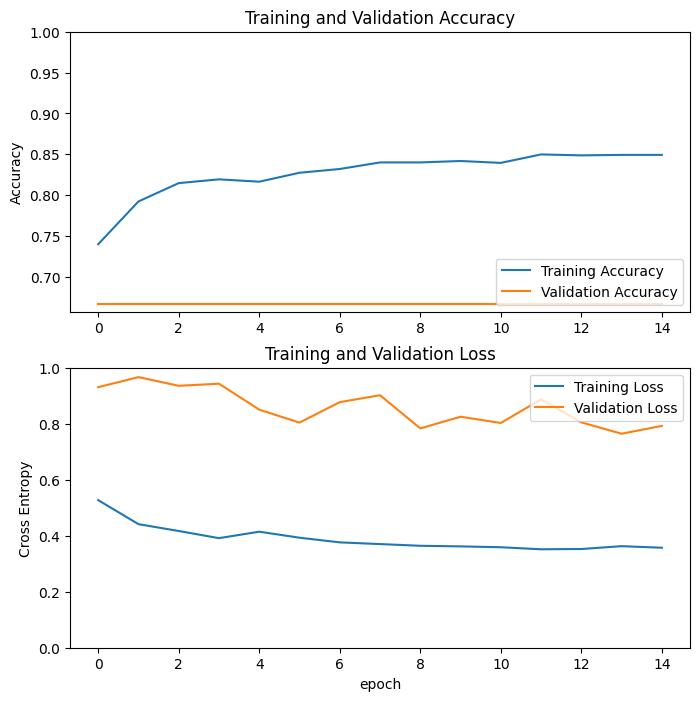

In [19]:
acc = history_hospital_1.history['accuracy']
val_acc = history_hospital_1.history['val_accuracy']

loss = history_hospital_1.history['loss']
val_loss = history_hospital_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
print("Number of layers in the base model: ", len(base_model_hospital_1.layers))

Number of layers in the base model:  513


In [21]:
base_model_hospital_1.trainable = True
for layer in base_model_hospital_1.layers[:400]:
  layer.trainable = False

In [22]:
model_transfer_hospital_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn')],
)

In [23]:
initial_epochs = 25
fine_tune_epochs = 15

total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model_transfer_hospital_1.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = total_epochs,
    initial_epoch = len(history_hospital_1.epoch),
    callbacks = [callback]
)

Epoch 16/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 118s 256ms/step - accuracy: 0.7697 - f1: 0.7021 - fn: 187.9772 - loss: 0.4822 - pn: 0.7697 - rc: 0.7697 - val_accuracy: 0.8333 - val_f1: 0.8286 - val_fn: 1.0000 - val_loss: 0.6909 - val_pn: 0.8333 - val_rc: 0.8333
Epoch 17/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8418 - f1: 0.7858 - fn: 146.3242 - loss: 0.3777 - pn: 0.8418 - rc: 0.8418 - val_accuracy: 0.6667 - val_f1: 0.6667 - val_fn: 2.0000 - val_loss: 0.7261 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 18/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8582 - f1: 0.8028 - fn: 126.7169 - loss: 0.3526 - pn: 0.8582 - rc: 0.8582 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.4558 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 19/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8690 - f1: 0.8182 - fn: 121.3881 - loss: 0.3429 - pn: 0.8690 - rc: 0.8690 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 1.1197 - val_pn: 0.6667 - va

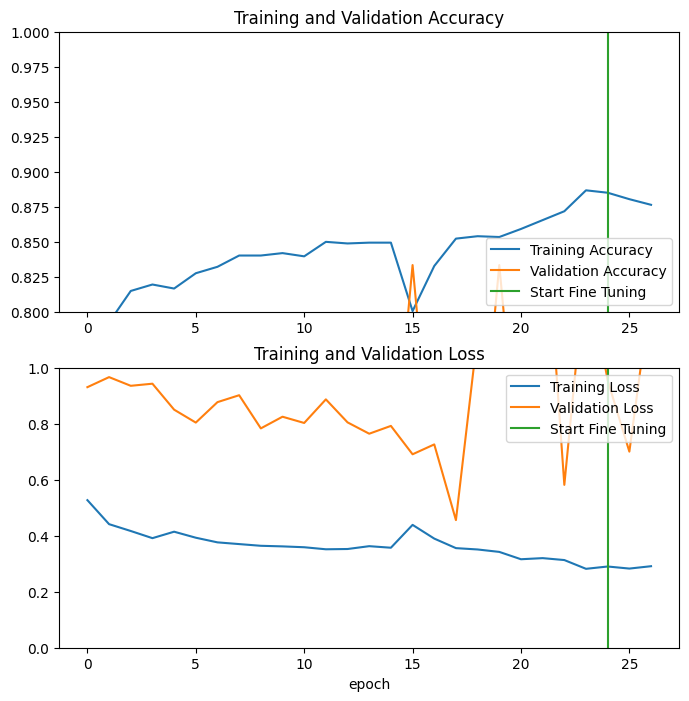

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
reasult = model_transfer_hospital_1.evaluate(test_ds_hospital_1)
print('Test accuracy :', reasult)

2025-12-04 16:56:25.219524: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 4 bytes spill stores, 4 bytes spill loads

2025-12-04 16:56:25.286705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 12 bytes spill stores, 12 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7583 - f1: 0.7081 - fn: 25.3333 - loss: 0.7124 - pn: 0.7583 - rc: 0.7583
Test accuracy : [0.6040990948677063, 0.7884615659713745, 0.7884615659713745, 0.7884615659713745, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.66666657, 0.84507036], dtype=float32)>, 44.0]


In [26]:
weight_hospital_1 = model_transfer_hospital_1.save_weights("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/model_hospital_1.weights.h5")

# HOSPITAL 2


### DATASET PREPARATION

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_2/train",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/val",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_2/test",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)


normalization_layer = tf.keras.layers.Rescaling(1./99)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds_hospital_2 = train_dataset.cache().prefetch(buffer_size=0)
val_ds_hospital_2 = validation_dataset.cache().prefetch(buffer_size=0)
test_ds_hospital_2 = test_dataset.cache().prefetch(buffer_size=0)



Found 1739 files belonging to 2 classes.
Found 6 files belonging to 2 classes.
Found 208 files belonging to 2 classes.


### MODEL TRAINING

In [31]:
IMG_SHAPE = (100,100,3)
base_model_hospital_2 = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
    include_preprocessing=True
)
base_model_hospital_2.trainable = False



In [32]:
inputs = tf.keras.Input(shape=(100,100,3))
x = base_model_hospital_2(inputs, training=False)  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model_transfer_hospital_2 = tf.keras.Model(inputs, outputs)

In [33]:
model_transfer_hospital_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn')],
)

In [34]:
history_2 = model_transfer_hospital_2.fit(
    train_ds_hospital_2,
    validation_data = val_ds_hospital_2,
    epochs = 25,
    callbacks = [callback]
)

Epoch 1/25


2025-12-04 16:10:18.805033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 8 bytes spill stores, 8 bytes spill loads

2025-12-04 16:10:18.878978: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 12 bytes spill stores, 12 bytes spill loads



217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7297 - f1: 0.4992 - fn: 226.1336 - loss: 0.5478 - pn: 0.7297 - rc: 0.7297

2025-12-04 16:10:48.690617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 8 bytes spill stores, 8 bytes spill loads

2025-12-04 16:10:48.772257: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23359', 12 bytes spill stores, 12 bytes spill loads



218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7298 - f1: 0.4994 - fn: 227.1101 - loss: 0.5476 - pn: 0.7298 - rc: 0.7298

2025-12-04 16:11:06.381158: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 4 bytes spill stores, 4 bytes spill loads

2025-12-04 16:11:06.427110: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 12 bytes spill stores, 12 bytes spill loads



218/218 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.7299 - f1: 0.4996 - fn: 228.0776 - loss: 0.5475 - pn: 0.7299 - rc: 0.7299 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 3.0000 - val_loss: 1.0042 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7762 - f1: 0.6065 - fn: 193.5342 - loss: 0.4684 - pn: 0.7762 - rc: 0.7762 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 3.0000 - val_loss: 0.9696 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8042 - f1: 0.6892 - fn: 171.7945 - loss: 0.4199 - pn: 0.8042 - rc: 0.8042 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.8951 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8277 - f1: 0.7428 - fn: 155.5479 - loss: 0.3740 - pn: 0.8277 - rc: 0.8277 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.8499 - val_pn: 0.6667 - val_rc: 0.6667
Epoch

In [37]:
base_model_hospital_2.trainable = True
for layer in base_model_hospital_2.layers[:400]:
  layer.trainable = False

In [38]:
model_transfer_hospital_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn')],
)

In [39]:
initial_epochs = 25
fine_tune_epochs = 15

total_epochs =  initial_epochs + fine_tune_epochs
history_fine_hospital_2 = model_transfer_hospital_2.fit(
    train_ds_hospital_2,
    validation_data = val_ds_hospital_2,
    epochs = total_epochs,
    initial_epoch = len(history_2.epoch),
    callbacks = [callback]
)

Epoch 17/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 87s 181ms/step - accuracy: 0.7908 - f1: 0.7373 - fn: 171.5525 - loss: 0.4633 - pn: 0.7908 - rc: 0.7908 - val_accuracy: 0.8333 - val_f1: 0.8286 - val_fn: 1.0000 - val_loss: 0.3848 - val_pn: 0.8333 - val_rc: 0.8333
Epoch 18/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8632 - f1: 0.8124 - fn: 124.4886 - loss: 0.3240 - pn: 0.8632 - rc: 0.8632 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.6435 - val_pn: 0.6667 - val_rc: 0.6667
Epoch 19/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8597 - f1: 0.8064 - fn: 120.6393 - loss: 0.3098 - pn: 0.8597 - rc: 0.8597 - val_accuracy: 0.8333 - val_f1: 0.8286 - val_fn: 1.0000 - val_loss: 0.6275 - val_pn: 0.8333 - val_rc: 0.8333
Epoch 20/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8898 - f1: 0.8517 - fn: 95.8995 - loss: 0.2670 - pn: 0.8898 - rc: 0.8898 - val_accuracy: 0.6667 - val_f1: 0.6250 - val_fn: 2.0000 - val_loss: 0.6931 - val_pn: 0.6667 - val_rc

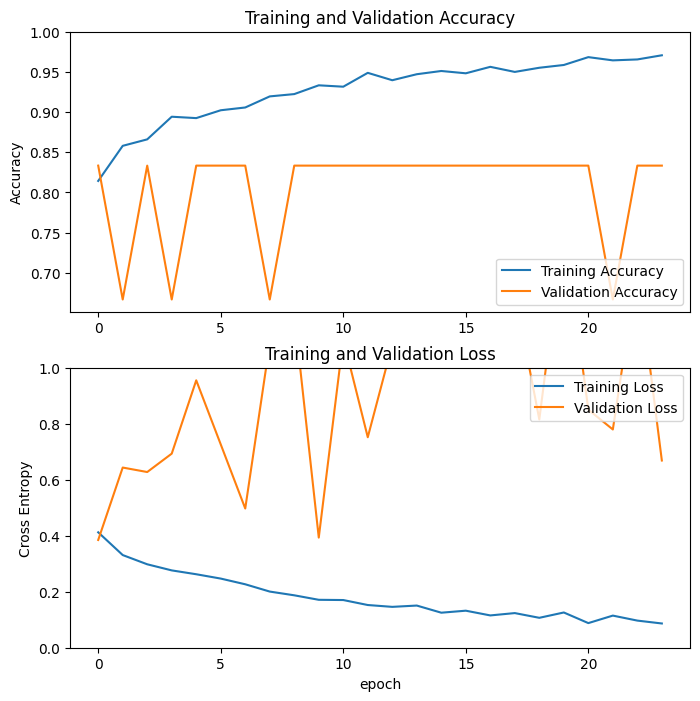

In [40]:
acc = history_fine_hospital_2.history['accuracy']
val_acc = history_fine_hospital_2.history['val_accuracy']

loss = history_fine_hospital_2.history['loss']
val_loss = history_fine_hospital_2.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
reasult = model_transfer_hospital_2.evaluate(test_ds_hospital_2)
print('Test accuracy :', reasult)

2025-12-04 16:18:03.292041: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 4 bytes spill stores, 4 bytes spill loads

2025-12-04 16:18:03.359643: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 12 bytes spill stores, 12 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7570 - f1: 0.7134 - fn: 26.9259 - loss: 0.7988 - pn: 0.7570 - rc: 0.7570
Test accuracy : [0.7065857648849487, 0.754807710647583, 0.754807710647583, 0.754807710647583, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.6277372 , 0.81720424], dtype=float32)>, 51.0]


In [42]:
weight_hospital_2 = model_transfer_hospital_2.save_weights("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_2/model_hospital_2.weights.h5")

# HOSPITAL 3

### DATASET PREPARATION

In [12]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_3/train",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_3/val",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_3/test",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)


normalization_layer = tf.keras.layers.Rescaling(1./99)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

train_ds_hospital_3 = train_dataset.cache().prefetch(buffer_size=0)
val_ds_hospital_3 = validation_dataset.cache().prefetch(buffer_size=0)
test_ds_hospital_3 = test_dataset.cache().prefetch(buffer_size=0)



Found 1738 files belonging to 2 classes.
Found 4 files belonging to 2 classes.
Found 208 files belonging to 2 classes.


### MODEL TRAINING

In [47]:
IMG_SHAPE = (100,100,3)
base_model_hospital_3 = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=2,
    classifier_activation='softmax',
    include_preprocessing=True
)
base_model_hospital_3.trainable = False



In [48]:
inputs = tf.keras.Input(shape=(100,100,3))
x = base_model_hospital_2(inputs, training=False)  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model_transfer_hospital_3 = tf.keras.Model(inputs, outputs)

In [49]:
model_transfer_hospital_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn')]
)

In [50]:
history_3 = model_transfer_hospital_3.fit(
    train_ds_hospital_3,
    validation_data = val_ds_hospital_3,
    epochs = 25,
    callbacks = [callback]
)

Epoch 1/25
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7795 - f1: 0.7364 - fn: 147.7972 - loss: 0.4389 - pn: 0.7795 - rc: 0.7795

2025-12-04 16:21:09.598129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27638', 8 bytes spill stores, 8 bytes spill loads

2025-12-04 16:21:09.692064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27638', 12 bytes spill stores, 12 bytes spill loads

2025-12-04 16:21:15.467855: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-04 16:21:15.681476: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-04 16:21:16.855139: E external/local_xla/x

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7798 - f1: 0.7367 - fn: 148.3073 - loss: 0.4385 - pn: 0.7798 - rc: 0.7798

2025-12-04 16:21:42.228982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 4 bytes spill stores, 4 bytes spill loads

2025-12-04 16:21:42.282326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4317', 12 bytes spill stores, 12 bytes spill loads

2025-12-04 16:21:45.748524: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=0} for conv (f32[4,512,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,512,7,7]{3,2,1,0}, f32[512,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=512, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"

218/218 ━━━━━━━━━━━━━━━━━━━━ 121s 314ms/step - accuracy: 0.7801 - f1: 0.7370 - fn: 148.8128 - loss: 0.4381 - pn: 0.7801 - rc: 0.7801 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 2.0000 - val_loss: 1.0629 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9027 - f1: 0.8693 - fn: 81.3470 - loss: 0.2496 - pn: 0.9027 - rc: 0.9027 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 2.0000 - val_loss: 1.8067 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9193 - f1: 0.8917 - fn: 67.9224 - loss: 0.2156 - pn: 0.9193 - rc: 0.9193 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 2.0000 - val_loss: 1.2264 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9305 - f1: 0.9057 - fn: 59.6210 - loss: 0.1942 - pn: 0.9305 - rc: 0.9305 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_fn: 2.0000 - val_loss: 1.8012 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 5

In [51]:
base_model_hospital_3.trainable = True
for layer in base_model_hospital_3.layers[:400]:
  layer.trainable = False


In [52]:
model_transfer_hospital_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1')],
)

In [53]:
initial_epochs = 25
fine_tune_epochs = 15

total_epochs =  initial_epochs + fine_tune_epochs
history_fine_hospital_3 = model_transfer_hospital_3.fit(
    train_ds_hospital_3,
    validation_data = val_ds_hospital_3,
    epochs = total_epochs,
    initial_epoch = len(history_3.epoch)
)

Epoch 19/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 116s 227ms/step - accuracy: 0.9780 - f1: 0.9708 - loss: 0.0819 - pn: 0.9780 - rc: 0.9780 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_loss: 3.0337 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 20/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9663 - f1: 0.9551 - loss: 0.0814 - pn: 0.9663 - rc: 0.9663 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_loss: 1.9701 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 21/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9730 - f1: 0.9642 - loss: 0.0814 - pn: 0.9730 - rc: 0.9730 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_loss: 3.4507 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 22/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9660 - f1: 0.9559 - loss: 0.0897 - pn: 0.9660 - rc: 0.9660 - val_accuracy: 0.5000 - val_f1: 0.3333 - val_loss: 2.4241 - val_pn: 0.5000 - val_rc: 0.5000
Epoch 23/40
218/218 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9855 - f1: 0.9809 - loss: 0.0514 - pn: 0.9855 - r

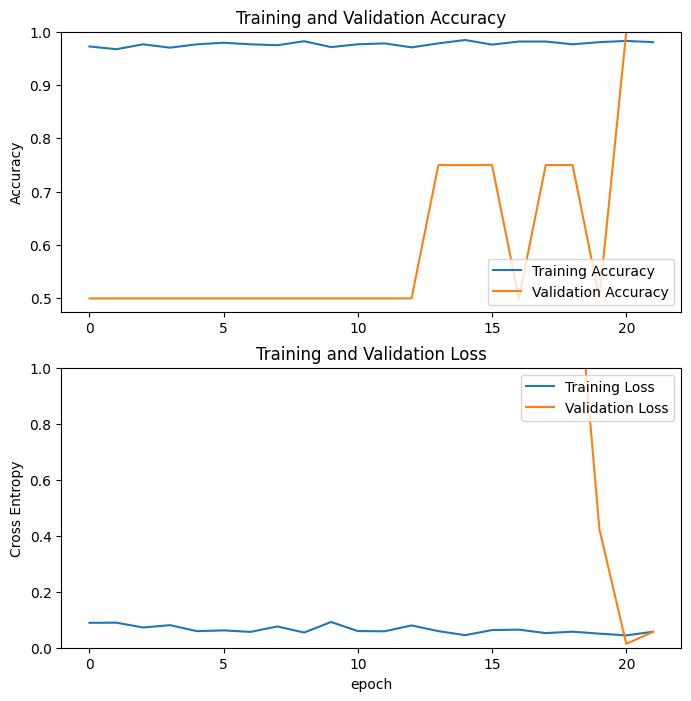

In [54]:
acc = history_fine_hospital_3.history['accuracy']
val_acc = history_fine_hospital_3.history['val_accuracy']

loss = history_fine_hospital_3.history['loss']
val_loss = history_fine_hospital_3.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
reasult = model_transfer_hospital_3.evaluate(test_ds_hospital_3)
print('Test accuracy :', reasult)

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7739 - f1: 0.7422 - loss: 1.1965 - pn: 0.7739 - rc: 0.7739
Test accuracy : [1.1526081562042236, 0.75, 0.75, 0.75, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.67499995, 0.79687494], dtype=float32)>]


In [56]:
weight_hospital_3 = model_transfer_hospital_3.save_weights("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_3/model_hospital_3.weights.h5")

# FEDERATED LEARNING

In [13]:
dataset_size_hospital_1 = sum(1 for _ in train_ds_hospital_1.unbatch())
dataset_size_hospital_2 = sum(1 for _ in train_ds_hospital_2.unbatch())
dataset_size_hospital_3 = sum(1 for _ in train_ds_hospital_3.unbatch())

2025-12-04 20:13:23.751872: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-04 20:13:30.977812: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### DIFFERENTIAL PRIVACY

In [14]:
def add_dp_noise(weights, noise_scale=1e-7):
    noisy = []
    for w in weights:
        noise = np.random.normal(loc=0, scale=noise_scale, size=w.shape)
        noisy.append(w + noise)
    return noisy

In [15]:
def fed_avg(weight_list, sample_counts):
    total = sum(sample_counts)
    num_layers = len(weight_list[0])
    averaged = []

    for i in range(num_layers):
        layer = sum(weight_list[k][i] * sample_counts[k] 
                    for k in range(len(weight_list))) / total
        averaged.append(layer)
    return averaged

In [38]:
def build_model(weights):
    IMG_SHAPE = (100,100,3)
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=IMG_SHAPE,
        pooling=None,
        classes=2,
        classifier_activation='softmax',
        include_preprocessing=True
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(100,100,3))
    x = base_model(inputs, training=False)  
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
               loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(name = 'pn'),tf.keras.metrics.Recall(name = 'rc'),tf.keras.metrics.F1Score(name='f1'),tf.keras.metrics.FalseNegatives(name='fn'),tf.keras.metrics.FalsePositives(name='fp'),tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.TruePositives(name='tp')],
    )


    if type(weights) is list:
        model.set_weights(weights)
    else:
        model.load_weights(weights)
    return model

In [39]:
model_hospital_1 = build_model("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_1/model_hospital_1.weights.h5")
model_hospital_2 = build_model("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_2/model_hospital_2.weights.h5")
model_hospital_3 = build_model("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/hospital_3/model_hospital_3.weights.h5")

/home/ratul/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 204 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
global_weights = fed_avg(
    [add_dp_noise(model_hospital_1.get_weights()), add_dp_noise(model_hospital_2.get_weights()), add_dp_noise(model_hospital_3.get_weights())],
    [dataset_size_hospital_1, dataset_size_hospital_2, dataset_size_hospital_3]
)

In [41]:
global_model = build_model(global_weights)

In [42]:
ROUNDS = 5
for round_num in range(ROUNDS):
    print(f"\n--- ROUND {round_num+1} ---")


    global_weights = global_model.get_weights()
    model_hospital_1.set_weights(global_weights)
    model_hospital_2.set_weights(global_weights)
    model_hospital_3.set_weights(global_weights)

 
    model_hospital_1.fit(train_ds_hospital_1, epochs=1, verbose=1)
    model_hospital_2.fit(train_ds_hospital_2, epochs=1, verbose=1)
    model_hospital_3.fit(train_ds_hospital_3, epochs=1, verbose=1)

    weights_A = model_hospital_1.get_weights()
    weights_B = model_hospital_2.get_weights()
    weights_C = model_hospital_3.get_weights()

    if round_num > 0:
        weights_A = add_dp_noise(weights_A)
        weights_B = add_dp_noise(weights_B)
        weights_C = add_dp_noise(weights_C)

    new_global_weights = fed_avg(
        [weights_A, weights_B, weights_C],
        [dataset_size_hospital_1, dataset_size_hospital_2, dataset_size_hospital_3]
    )

    global_model.set_weights(new_global_weights)

    print("Global model updated.")

weight_hospital_global = global_model.save_weights("/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/HOSPITAL/global_model.weights.h5")


--- ROUND 1 ---
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 110ms/step - accuracy: 0.8995 - f1: 0.8616 - fn: 83.8447 - fp: 83.8447 - loss: 0.3223 - pn: 0.8995 - rc: 0.8995 - tn: 796.0731 - tp: 796.0731
218/218 ━━━━━━━━━━━━━━━━━━━━ 63s 115ms/step - accuracy: 0.9118 - f1: 0.8778 - fn: 82.9269 - fp: 82.9269 - loss: 0.3073 - pn: 0.9118 - rc: 0.9118 - tn: 796.9908 - tp: 796.9908
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 128ms/step - accuracy: 0.9131 - f1: 0.8837 - fn: 78.1370 - fp: 78.1370 - loss: 0.3037 - pn: 0.9131 - rc: 0.9131 - tn: 801.7717 - tp: 801.7717
Global model updated.

--- ROUND 2 ---
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8969 - f1: 0.8579 - fn: 89.4658 - fp: 89.4658 - loss: 0.3008 - pn: 0.8969 - rc: 0.8969 - tn: 790.4520 - tp: 790.4520
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9165 - f1: 0.8835 - fn: 74.7123 - fp: 74.7123 - loss: 0.2816 - pn: 0.9165 - rc: 0.9165 - tn: 805.2055 - tp: 805.2055
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9043 - f1: 0.8703

In [ ]:
global_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "/mnt/d/RATUL/COMPUTER PROGRAMMING AND CODING/TENSORFLOW/MEDICAL HACKATHON/GLOBAL_TEST_DATASET",
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 8,
    image_size = (100, 100),
    shuffle = True,
    class_names = ["NORMAL", "PNEUMONIA"]
)
normalization_layer = tf.keras.layers.Rescaling(1./99)
global_test_dataset = global_test_dataset.map(lambda x, y: (normalization_layer(x), y))

global_test_dataset = global_test_dataset.cache().prefetch(buffer_size=0)


Found 624 files belonging to 2 classes.


# GLOBAL MODEL EVALUATION

In [50]:
# This is the cleanest solution
results_global = global_model.evaluate(global_test_dataset, return_dict=True)

print(results_global)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8365 - f1: 0.8171 - fn: 54.8608 - fp: 54.8608 - loss: 0.3789 - pn: 0.8365 - rc: 0.8365 - tn: 265.0380 - tp: 265.0380
{'accuracy': 0.8237179517745972, 'f1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7544642, 0.8624999], dtype=float32)>, 'fn': 110.0, 'fp': 110.0, 'loss': 0.40240588784217834, 'pn': 0.8237179517745972, 'rc': 0.8237179517745972, 'tn': 514.0, 'tp': 514.0}


In [52]:
print("Hospital 1 Evaluation:")
reasult_hospital_1 = global_model.evaluate(test_ds_hospital_1, return_dict=True)
print(reasult_hospital_1)

print("Hospital 2 Evaluation:")
reasult_hospital_2 = global_model.evaluate(test_ds_hospital_2, return_dict=True)
print(reasult_hospital_2)

print("Hospital 3 Evaluation:")
reasult_hospital_3 = global_model.evaluate(test_ds_hospital_3, return_dict=True)
print(reasult_hospital_3)

Hospital 1 Evaluation:
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7956 - f1: 0.7651 - fn: 22.0741 - fp: 22.0741 - loss: 0.4588 - pn: 0.7956 - rc: 0.7956 - tn: 89.6296 - tp: 89.6296
{'accuracy': 0.8125, 'f1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.73103446, 0.8560885 ], dtype=float32)>, 'fn': 39.0, 'fp': 39.0, 'loss': 0.41457879543304443, 'pn': 0.8125, 'rc': 0.8125, 'tn': 169.0, 'tp': 169.0}
Hospital 2 Evaluation:
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8249 - f1: 0.8144 - fn: 18.6667 - fp: 18.6667 - loss: 0.4211 - pn: 0.8249 - rc: 0.8249 - tn: 93.0370 - tp: 93.0370
{'accuracy': 0.8365384340286255, 'f1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7671232 , 0.87407404], dtype=float32)>, 'fn': 34.0, 'fp': 34.0, 'loss': 0.39400988817214966, 'pn': 0.8365384340286255, 'rc': 0.8365384340286255, 'tn': 174.0, 'tp': 174.0}
Hospital 3 Evaluation:
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8269 - f1: 0.8186 - fn: 20.1111 - fp: 20.1111 -

In [ ]:
def extract_metrics(result_dict):
    return {
        "loss": result_dict["loss"],
        "accuracy": result_dict["accuracy"],
        "precision": result_dict["pn"],
        "recall": result_dict["rc"],
        "f1_avg": float((result_dict["f1"][0] + result_dict["f1"][1]) / 2), 
        "false negatives": result_dict["fn"],
        "false positives": result_dict["fp"],
        "true negatives": result_dict["tn"],
        "true positives": result_dict["tp"]
    }

bias_table = pd.DataFrame([
    extract_metrics(reasult_hospital_1),
    extract_metrics(reasult_hospital_2),
    extract_metrics(reasult_hospital_3),
    extract_metrics(results_global)
], 
index=["Hospital 1", "Hospital 2", "Hospital 3", "Global Model"])

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
pd.set_option("display.max_colwidth", 100)

print(bias_table)


                  loss  accuracy  precision    recall    f1_avg  false negatives  false positives  true negatives  true positives
Hospital 1    0.414579  0.812500   0.812500  0.812500  0.793561             39.0             39.0           169.0           169.0
Hospital 2    0.394010  0.836538   0.836538  0.836538  0.820599             34.0             34.0           174.0           174.0
Hospital 3    0.398629  0.822115   0.822115  0.822115  0.810737             37.0             37.0           171.0           171.0
Global Model  0.402406  0.823718   0.823718  0.823718  0.808482            110.0            110.0           514.0           514.0


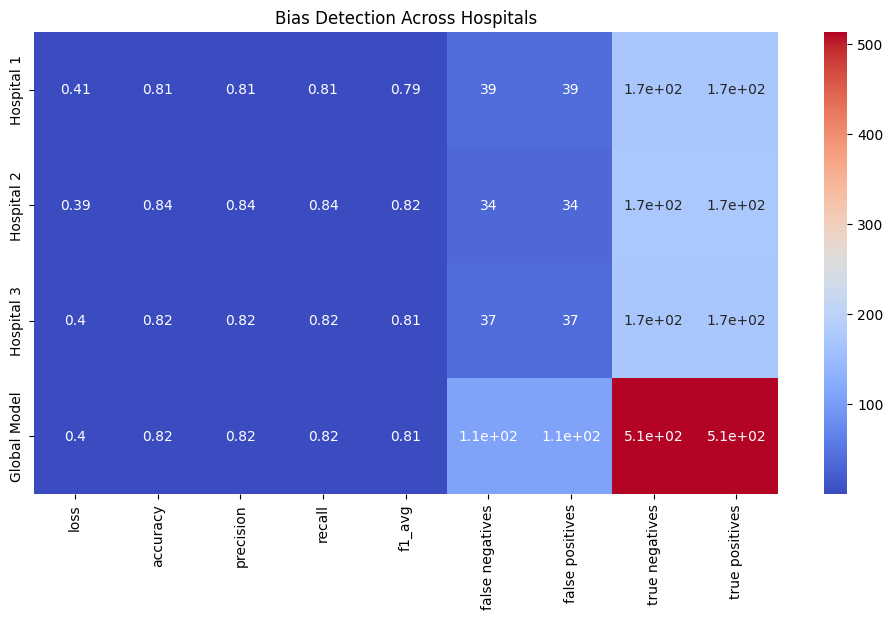

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(bias_table, annot=True, cmap="coolwarm")
plt.title("Bias Detection Across Hospitals")
plt.show()